## Домашка

### Задание 1 (8 баллов)
Обучите модель с минимум 15 слоями, где у каждого слоя разные параметры (Dropout, Conv1d и Pooling, Dense считаются слоями, остальное нет, но их тоже можно использовать). Как минимум 4 слоя должны быть наложены друг на друга и как минимум 2 параллельных слоя (последовательности слоев). Должен быть хотя бы один слой каждого типа.

При обучении используйте колбек для отслеживания лучшей модели. Ориентируйтесь на Recall@Precision меру. Качество модели не должно быть околонулевым. Если метрики не растут, то попробуйте пообучать подольше или перестроить саму сеть.

Советы: Начните с небольших сетей и постепенно добавляйте, не пытайтесь сразу собрать все слои. Иногда кернел может крашиться просто так или из-за слишком больших матриц.


### Задание 2 (2 балла)
Обучите нейросеть со сверточными слоями с архитектурой похожей на Unet - https://en.wikipedia.org/wiki/U-Net

Не нужно воспроизводить все в точности, главное, чтобы было сокращение длины последовательности с помощью CNN, а затем обратное увеличение длины последовательности до изначальной с residual связями между промежуточными шагами с одинаковыми размерностями.
Изменений размерности должно быть хотя бы 3 и соответственно residual связей тоже.

Для повышения размерности используйте keras.layers.UpSampling1D
Полученная модель должна давать ненулевое качество на той же самой задаче классификации текстов.

In [1]:
!pip install pymorphy3 --q

In [1]:
import os
os.environ["KERAS_BACKEND"] = "torch"

In [2]:
import keras
import pandas as pd
import numpy as np
from string import punctuation
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import torch
# torch.set_default_device('cpu')

In [5]:
!unzip lenta_40k.csv.zip

Archive:  lenta_40k.csv.zip
replace lenta_40k.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [4]:
data = pd.read_csv('lenta_40k.csv')
data

,text,topic
0,Россия должна сотрудничать с Всемирным антидоп...,Спорт
1,Уголовный суд Кувейта 28 июня освободил под за...,Мир
2,Французский журнал Charlie Hebdo опубликовал н...,Интернет и СМИ
3,В Петербурге в доме № 53 по улице Лени Голиков...,Россия
4,"В московском аэропорту ""Домодедово"" задержан г...",Россия
...,...,...
44351,Российский Минфин может пересмотреть минимальн...,Экономика
44352,Сотрудники Службы безопасности Украины (СБУ) с...,Бывший СССР
44353,Америке следует задуматься над поставками на У...,Силовые структуры
44354,"Опознаны тела 71 человека, погибшего в результ...",Мир


In [5]:
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from string import punctuation
import pymorphy3

nltk.download('punkt_tab')

def preprocess(text):
    tokens = re.sub('#+', ' ', text.lower())
    tokens = word_tokenize(text)
    morph = pymorphy3.MorphAnalyzer()

    processed_tokens = []
    for token in tokens:
        if token and token not in punctuation:
            processed_tokens.append(morph.parse(token)[0].normal_form)

    return processed_tokens

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [6]:
from google.colab import drive
import pickle
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
vocab = Counter()

for text in tqdm(data.text):
    vocab.update(preprocess(text))

In [ ]:
with open("/content/drive/MyDrive/unfiltered_vocab_lenta.pkl", 'wb') as f:
    pickle.dump(vocab, f)

In [ ]:
filtered_vocab = set()

for word in tqdm(vocab):
    if vocab[word] > 30:
        filtered_vocab.add(word)

In [ ]:
with open("/content/drive/MyDrive/filtered_vocab_lenta.pkl", 'wb') as f:
    pickle.dump(filtered_vocab, f)

In [7]:
with open("/content/drive/MyDrive/filtered_vocab_lenta.pkl", 'rb') as f:
    filtered_vocab = pickle.load(f)

In [8]:
word2id = {'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [9]:
id2word = {i:word for word, i in word2id.items()}

In [ ]:
X = []

for text in tqdm(data.text[:20000]):
    tokens = preprocess(text)
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

In [ ]:
with open("/content/drive/MyDrive/lenta_ids.pkl", "wb") as f:
    pickle.dump(X, f)

In [10]:
with open("/content/drive/MyDrive/lenta_ids.pkl", "rb") as f:
    X = pickle.load(f)

In [11]:
MAX_LEN = 512

In [12]:
X = keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN)

In [13]:
X.shape

(20000, 512)

In [14]:
id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}

In [15]:
y = keras.utils.to_categorical([label2id[label] for label in data[:20000].topic.values])

In [16]:
y.shape

(20000, 19)

In [17]:
len(label2id)

19

In [18]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05, random_state=42)

In [19]:
checkpoint = keras.callbacks.ModelCheckpoint('model.weights.h5', # названия файла
                                                monitor='val_rec@prec', # за какой метрикой следить
                                                verbose=1, # будет печатать что происходит
                                                save_weights_only=True, # если нужно только веса сохранить
                                                save_best_only=True, # сохранять только лучшие
                                                mode='max', # если метрика должна расти, то тут max и min если наоборот
                                                save_freq='epoch' # как часто вызывать
                                               )

# EarlyStopping позволяет автоматически остановить обучение, если качество не улучшается
early_stop = keras.callbacks.EarlyStopping(monitor='val_rec@prec',
                                              min_delta=0.01, # какая разница считается как улучшение
                                              patience=7, # сколько эпох терпеть отсутствие улучшений
                                              verbose=1,
                                              mode='max',
                                              )

In [20]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs, )
convs = []

for ks in [3,4,5,7,10]:
    conv1 = keras.layers.Conv1D(kernel_size=ks, filters=32, padding='same',strides=1)(embeddings)
    conv2 = keras.layers.Conv1D(kernel_size=ks, filters=24, padding='same',strides=1,
                                  kernel_regularizer='l2', activation='relu')(conv1)
    pool = keras.layers.AveragePooling1D(pool_size=10, strides=5)(conv2)
    convs.append(pool)


concat = keras.layers.concatenate(convs, axis=2)

# а тут мы можем поставить еще свертку
conv_global = keras.layers.Conv1D(kernel_size=5, filters=32, strides=1)(concat)
flatten = keras.layers.Flatten()(conv_global)
dense = keras.layers.Dense(50, activation='relu')(flatten)
outputs = keras.layers.Dense(len(label2id), activation='softmax')(dense)

model = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

In [21]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 512)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 512, 100)       │      1,431,800 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 512, 32)        │          9,632 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_2 (Conv1D)         │ (None, 512, 32)        │         12,832 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_4 (Conv1D)         │ (None, 512, 32)        │         16,032 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_6 (Conv1D)         │ (None, 512, 32)        │         22,432 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_8 (Conv1D)         │ (None, 512, 32)        │         32,032 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_1 (Conv1D)         │ (None, 512, 24)        │          2,328 │ conv1d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_3 (Conv1D)         │ (None, 512, 24)        │          3,096 │ conv1d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_5 (Conv1D)         │ (None, 512, 24)        │          3,864 │ conv1d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_7 (Conv1D)         │ (None, 512, 24)        │          5,400 │ conv1d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_9 (Conv1D)         │ (None, 512, 24)        │          7,704 │ conv1d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ average_pooling1d         │ (None, 101, 24)        │              0 │ conv1d_1[0][0]         │
│ (AveragePooling1D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ average_pooling1d_1       │ (None, 101, 24)        │              0 │ conv1d_3[0][0]         │
│ (AveragePooling1D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ average_pooling1d_2       │ (None, 101, 24)        │              0 │ conv1d_5[0][0]         │
│ (AveragePooling1D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ average_pooling1d_3       │ (None, 101, 24)        │              0 │ conv1d_7[0][0]         │
│ (AveragePooling1D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ average_pooling1d_4       │ (None, 101, 24)        │              0 │ conv1d_9[0][0]         │
│ (AveragePooling1D)        │                        │                │                        │
├──────────────────────

 Total params: 1,722,603 (6.57 MB)

 Trainable params: 1,722,603 (6.57 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Определяем, доступен ли GPU

model.to(device) # Переносим модель на GPU (если доступен)

X_train = torch.tensor(X_train).to(device)
y_train = torch.tensor(y_train).to(device)
X_valid = torch.tensor(X_valid).to(device)
y_valid = torch.tensor(y_valid).to(device)

In [23]:
model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=2000,
          epochs=100,
          callbacks=[checkpoint, early_stop])

/usr/local/lib/python3.11/dist-packages/keras/src/backend/torch/nn.py:466: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1036.)
  outputs = tnn.conv1d(


Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - loss: 1.5168 - rec@prec: 0.0000e+00
Epoch 1: val_rec@prec improved from -inf to 0.00000, saving model to model.weights.h5
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 550ms/step - loss: 1.5111 - rec@prec: 0.0000e+00 - val_loss: 1.2903 - val_rec@prec: 0.0000e+00
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 526ms/step - loss: 1.2355 - rec@prec: 0.0000e+00
Epoch 2: val_rec@prec did not improve from 0.00000
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 538ms/step - loss: 1.2310 - rec@prec: 0.0000e+00 - val_loss: 1.0550 - val_rec@prec: 0.0000e+00
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - loss: 1.0100 - rec@prec: 0.0000e+00
Epoch 3: val_rec@prec did not improve from 0.00000
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 543ms/step - loss: 1.0064 - rec@prec: 0.0000e+00 - val_loss: 0.8634 - val_rec@prec: 0.0000e+00
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 534ms/step - loss: 0.8253 - rec@prec: 3.4186e-04
Epoch 4: val_rec@prec improved from 0.00000 to 0.01600, saving model to m

dict_keys(['loss', 'rec@prec', 'val_loss', 'val_rec@prec'])


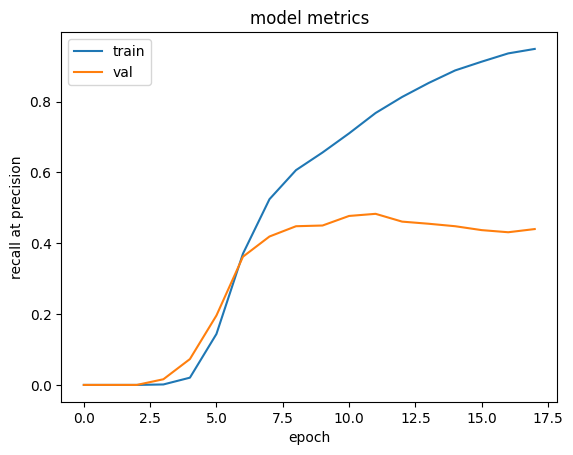

In [24]:
print(model.history.history.keys())
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model metrics')
plt.ylabel('recall at precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Задание 2

In [25]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs, )
conv1 = keras.layers.Conv1D(kernel_size=5, filters=32, padding='same', activation='relu')(embeddings)
max_pool1 = keras.layers.MaxPooling1D(2)(conv1) # 1/2
conv2 = keras.layers.Conv1D(kernel_size=5, filters=64, padding='same', activation='relu')(max_pool1)
max_pool2 = keras.layers.MaxPooling1D(2)(conv2) # 1/4
conv3 = keras.layers.Conv1D(kernel_size=5, filters=128, padding='same', activation='relu')(max_pool2)
max_pool3 = keras.layers.MaxPooling1D(2)(conv3) # 1/8
conv4 = keras.layers.Conv1D(kernel_size=5, filters=256, padding='same', activation='relu')(max_pool3)
up1 = keras.layers.UpSampling1D(2)(conv4) # 1/4
residual1 = keras.layers.concatenate([conv3, up1])
conv5 = keras.layers.Conv1D(kernel_size=5, filters=128, padding='same', activation='relu')(residual1)
up2 = keras.layers.UpSampling1D(2)(residual1) # 1/2
residual2 = keras.layers.concatenate([conv2, up2])
conv6 = keras.layers.Conv1D(kernel_size=5, filters=64, padding='same', activation='relu')(residual2)
up3 = keras.layers.UpSampling1D(2)(residual2)
residual3 = keras.layers.concatenate([conv1, up3])
conv6 = keras.layers.Conv1D(kernel_size=5, filters=32, padding='same', activation='relu')(residual3)
flatten = keras.layers.Flatten()(conv6)
dense = keras.layers.Dense(32, activation="relu")(flatten)
outputs = keras.layers.Dense(len(label2id), activation='softmax')(dense)

model = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

In [26]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 512)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 512, 100)       │      1,431,800 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_11 (Conv1D)        │ (None, 512, 32)        │         16,032 │ embedding_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d             │ (None, 256, 32)        │              0 │ conv1d_11[0][0]        │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_12 (Conv1D)        │ (None, 256, 64)        │         10,304 │ max_pooling1d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_1           │ (None, 128, 64)        │              0 │ conv1d_12[0][0]        │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_13 (Conv1D)        │ (None, 128, 128)       │         41,088 │ max_pooling1d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_2           │ (None, 64, 128)        │              0 │ conv1d_13[0][0]        │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_14 (Conv1D)        │ (None, 64, 256)        │        164,096 │ max_pooling1d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling1d             │ (None, 128, 256)       │              0 │ conv1d_14[0][0]        │
│ (UpSampling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 128, 384)       │              0 │ conv1d_13[0][0],       │
│ (Concatenate)             │                        │                │ up_sampling1d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling1d_1           │ (None, 256, 384)       │              0 │ concatenate_1[0][0]    │
│ (UpSampling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 256, 448)       │              0 │ conv1d_12[0][0],       │
│ (Concatenate)             │                        │                │ up_sampling1d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling1d_2           │ (None, 512, 448)       │              0 │ concatenate_2[0][0]    │
│ (UpSampling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_3             │ (None, 512, 480)       │              0 │ conv1d_11[0][0],       │
│ (Concatenate)        

 Total params: 2,265,099 (8.64 MB)

 Trainable params: 2,265,099 (8.64 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=2000,
          epochs=100,
          callbacks=[checkpoint, early_stop])

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 874ms/step - loss: 0.1927 - rec@prec: 0.0000e+00
Epoch 1: val_rec@prec did not improve from 0.48300
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 890ms/step - loss: 0.1919 - rec@prec: 0.0000e+00 - val_loss: 0.1762 - val_rec@prec: 0.0000e+00
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 845ms/step - loss: 0.1737 - rec@prec: 1.7069e-05
Epoch 2: val_rec@prec did not improve from 0.48300
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 860ms/step - loss: 0.1736 - rec@prec: 2.0302e-05 - val_loss: 0.1712 - val_rec@prec: 0.0000e+00
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 848ms/step - loss: 0.1673 - rec@prec: 2.3596e-05
Epoch 3: val_rec@prec did not improve from 0.48300
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 864ms/step - loss: 0.1671 - rec@prec: 2.6236e-05 - val_loss: 0.1614 - val_rec@prec: 0.0010
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 844ms/step - loss: 0.1566 - rec@prec: 2.5330e-04
Epoch 4: val_rec@prec did not improve from 0.48300
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 860ms/step - loss: 0.1563 - rec

dict_keys(['loss', 'rec@prec', 'val_loss', 'val_rec@prec'])


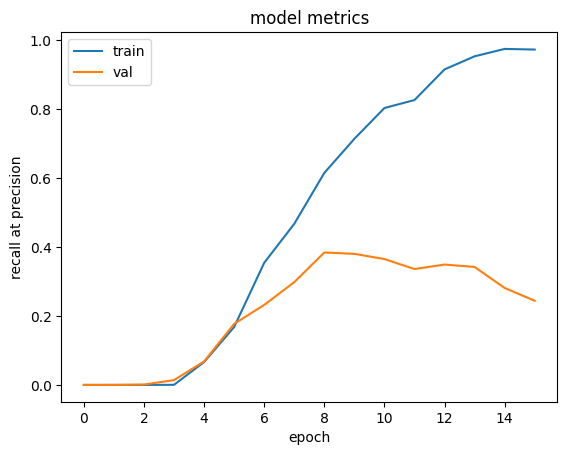

In [28]:
print(model.history.history.keys())
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model metrics')
plt.ylabel('recall at precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()